In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.plots import *
from torchtext.data import Field
from fastai.lm_rnn import seq2seq_reg
from quicknlp import SpacyTokenizer, print_batch, HierarchicalModelData
from pathlib import Path

In [3]:
!ls dataset/dialogue/

models	tmp  train  validation


In [12]:
!python -m spacy download en

    100% |████████████████████████████████| 37.4MB 3.0MB/s 
  Running setup.py install for en-core-web-sm ... done

    Linking successful
    /opt/conda/envs/fastai/lib/python3.6/site-packages/en_core_web_sm -->
    /opt/conda/envs/fastai/lib/python3.6/site-packages/spacy/data/en

    You can now load the model via spacy.load('en')



Data found from https://www.kaggle.com/rtatman/ubuntu-dialogue-corpus 

In [4]:
path = Path("./dataset/dialogue")

In [5]:
ubuntu_data = pd.read_csv(path / "train/dialogueText.csv")

In [6]:
ubuntu_data.shape

(1038324, 6)

In [7]:
ubuntu_data['dialogueID'].nunique()
sampled_dialogues = set(ubuntu_data['dialogueID'].sample(1000).tolist())
train_df = ubuntu_data.loc[ubuntu_data['dialogueID'].apply(lambda x: x in sampled_dialogues)]
#train_df = ubuntu_data

In [8]:
train_df.shape

(2997, 6)

In [9]:
ubuntu_data.columns

Index(['folder', 'dialogueID', 'date', 'from', 'to', 'text'], dtype='object')

In [10]:
from torchtext.data import field
from torchtext.data import Example

In [13]:
f = Field(tokenize="spacy", lower="True")

In [14]:
#columns to use when constructing the conversations
cols = {"text_col":"text", "batch_col":"dialogueID", "sort_col":"date", "role_col":"from"}

In [16]:
%pdb

Automatic pdb calling has been turned ON


In [ ]:
model_data = HierarchicalModelData.from_dataframes(path=path,
                                                   train_df=train_df,
                                                   val_df=train_df,
                                                   text_field=f,
                                                  **cols
                                                  )

processed file 0/1: 100%|██████████| 999/999 [00:01<00:00, 563.04it/s]


AssertionError: sort_key provided is not a function

> /opt/quicknlp/src/quicknlp/data/data_loaders.py(61)__init__()
     59                 return max(x.sl)
     60         else:
---> 61             assert callable(sort_key), "sort_key provided is not a function"
     62         self.dl = HierarchicalIterator(dataset, batch_size=batch_size, sort_key=sort_key, target_roles=target_names,
     63                                        max_context_size=max_context_size, **kwargs)

> /opt/quicknlp/src/quicknlp/data/hierarchical_model_data_loader.py(64)<listcomp>()
     62                                                           max_context_size=max_context_size, backwards=backwards)
     63                                    if ds is not None else None
---> 64                                    for ds in (trn_ds, val_ds, test_ds)]
     65         super().__init__(path=path, trn_dl=trn_dl, val_dl=val_dl, test_dl=test_dl)
     66         self.fields = trn_ds.fields



In [14]:
dl =iter(model_data.trn_dl)

In [15]:
%pdb

Automatic pdb calling has been turned ON


In [16]:
learner = model_data.get_model()

In [17]:
reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
clip = 0.3
learner.reg_fn = reg_fn
learner.clip = clip

In [18]:
learner.summary()

HRED(
  (query_encoder): EmbeddingRNNEncoder(
    (rnns): ModuleList(
      (0): Cell(
        (cell): WeightDrop(
          (module): GRU(300, 512, dropout=0.3)
        )
      )
      (1): Cell(
        (cell): WeightDrop(
          (module): GRU(512, 512, dropout=0.3)
        )
      )
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
      (1): LockedDropout(
      )
    )
    (encoder): Embedding(6151, 300, padding_idx=1)
    (encoder_with_dropout): EmbeddingDropout(
      (embed): Embedding(6151, 300, padding_idx=1)
    )
    (dropouti): LockedDropout(
    )
  )
  (session_encoder): RNNEncoder(
    (rnns): ModuleList(
      (0): Cell(
        (cell): WeightDrop(
          (module): GRU(512, 512, dropout=0.3)
        )
      )
    )
    (dropouths): ModuleList(
      (0): LockedDropout(
      )
    )
  )
  (decoder): EmbeddingRNNDecoder(
    (rnns): ModuleList(
      (0): Cell(
        (cell): WeightDrop(
          (module): GRU(300, 512, dropout=0.3)
        )


In [19]:
print_batch(lr=learner,dt=model_data, input_field="text", output_field="text",num_sentences=4)

batch: 0 sample : 0
input: 
target: cpuinfo | grep -e ' cpu ' -e '
prediction: ['lame lame software lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame']


batch: 0 sample : 1
input: 
target: _ hello _ _
prediction: ['lame lame hariezg software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame software lame lame lame software lame lame lame software lame lame softwar

In [20]:
learner.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.942455   nan       



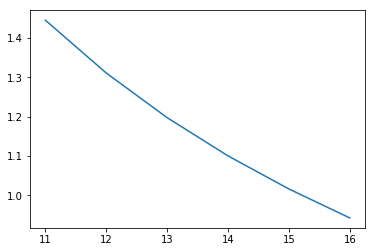

In [21]:
learner.sched.plot_loss()

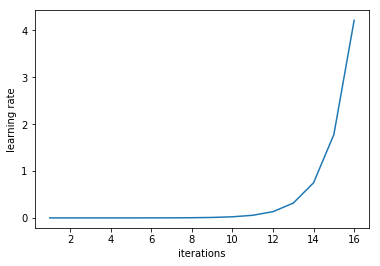

In [22]:
learner.sched.plot_lr()

In [23]:
learner.fit(lrs=0.01,n_cycle=2, cycle_len=2)

HBox(children=(IntProgress(value=0, description='Epoch', max=4), HTML(value='')))

epoch      trn_loss   val_loss                             
    0      0.942502   1.090958  
    1      0.933907   1.006068                             
    2      0.870118   1.073083                             
    3      0.878808   0.906142                             



[0.9061425]

In [ ]:
print_batch(lr=learner,dt=model_data, input_field="text", output_field="text",num_sentences=4)

[20] > /home/agis/PycharmProjects/personal/quick-nlp/src/quicknlp/utils.py(85)print_batch()
-> inputs = dt.itos(inputs[batch_num], input_field)[0]
(Pdb++) inputs
[array([[[   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2],
        [3483, 1845, 1848, ...,  825, 3573, 3575],
        ...,
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1]]]), array([[[   2,    2,    2, ...,    2,    2,    2],
        [   2,    2,    2, ...,    2,    2,    2],
        [3483, 1845, 1848, ...,  825, 3573, 3575],
        ...,
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1],
        [   1,    1,    1, ...,    1,    1,    1]],

       [[ 291,    8,    2, ..., 1644, 5549, 3130],
        [   2,  108,    2, ...,   23,   60,   49],
        [   2,   33,  114, ...,   18,    1, 1138],
        ...,
        [   1,    1,    1, .